In [1]:
using KernelDensityEstimate
using Gadfly
using Distributions, StatsBase
using IteratedProbabilisticClassification
# don't mind syntax warnings, these are being removed from package dependencies over time

    +(AbstractArray, DataArrays.DataArray) at /home/dehann/.julia/v0.4/DataArrays/src/operators.jl:276
is ambiguous with: 
    +(WoodburyMatrices.SymWoodbury, AbstractArray{T<:Any, 2}) at /home/dehann/.julia/v0.4/WoodburyMatrices/src/SymWoodburyMatrices.jl:107.
To fix, define 
    +(WoodburyMatrices.SymWoodbury, DataArrays.DataArray{T<:Any, 2})
before the new definition.
    +(AbstractArray, DataArrays.AbstractDataArray) at /home/dehann/.julia/v0.4/DataArrays/src/operators.jl:300
is ambiguous with: 
    +(WoodburyMatrices.SymWoodbury, AbstractArray{T<:Any, 2}) at /home/dehann/.julia/v0.4/WoodburyMatrices/src/SymWoodburyMatrices.jl:107.
To fix, define 
    +(WoodburyMatrices.SymWoodbury, DataArrays.AbstractDataArray{T<:Any, 2})
before the new definition.


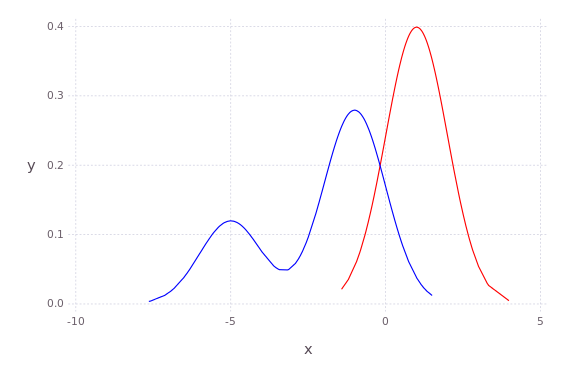

In [2]:
# modified EM classification algorithm has these major tuning parameter 
params = TuningParameters(
Mfair=200,   # Cluster distribution approximation accuracy, more is better: 50 is bare minium, and computation slow above ~1000
EMiters=40  # expectation maximization iterations to refine Cluster belief estimate classification assignments: 5 is minimum, and diminishing returns beyond ~70
)

# Example: simulated data with ground truth for reference
N1, N2 = 5000, 1000
data, groundtruth = simdata01_true(N1=N1,N2=N2)

Gadfly.set_default_plot_size(15cm, 10cm)
# a generic 1D plotting tool for IteratedProbablisticClassification 
plotUtil1D(groundtruth=groundtruth)

In [3]:
# belief from expert prediction, also used for initialization
c1_expert = kde!(3.5*randn(params.Mfair)-2.5); # Pretty much a normal distribution
c2_expert = kde!(2.0*randn(params.Mfair)+5.0); # Pretty much a normal distribution

# cs is the main structure which classification algorithm will operate on, and modify during execution
cs = ClassificationSystem(
2,                              # number of categories or classes available for assignment
Dict(1=>"class1", 2=>"class2"), # names of classes
Dict(1=>"blue", 2=>"red"),      # default plotting colors
Dict(1=>c1_expert, 2=>c2_expert), # user forcing behaviour (expert guidance); required
Dict(1=>deepcopy(c1_expert), 2=>deepcopy(c2_expert)), # initialize temporal prediction (forward-backward smoothing)
Dict(1=>deepcopy(c1_expert), 2=>deepcopy(c2_expert)), # initialize current belief (0 iterations)
rand(Categorical([0.5;0.5]),length(data.samples)) # initialize samples with random assignment, 50/50% in this 2 class case
);
println()

In [4]:
# expert may modify expertBelief using output from previous run of classification algorithm
# c1_expert = deepcopy(stats.ESTBELIEF[1][end]);
# c2_expert = deepcopy(stats.ESTBELIEF[2][end]);
# println()

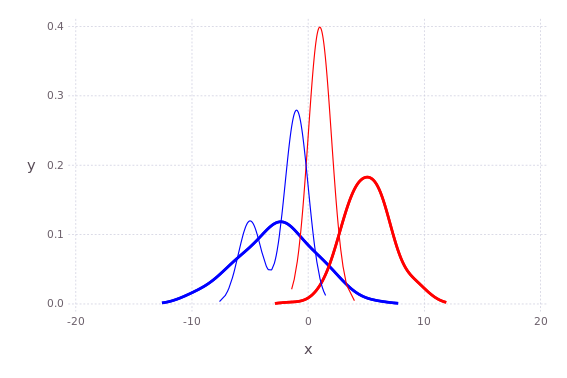

In [5]:
Gadfly.set_default_plot_size(15cm, 10cm)
# plotUtil1D(cs=cs) # if we didn't have gt
plotUtil1D(groundtruth=groundtruth, cs=cs)

In [6]:
# simulation data allows us to debug with absolute knowledge
dbg = defaultDebugResults()

# do the classification
stats = EMClassificationRun!(params, cs, data, debug=dbg, groundtruth=groundtruth);
println()

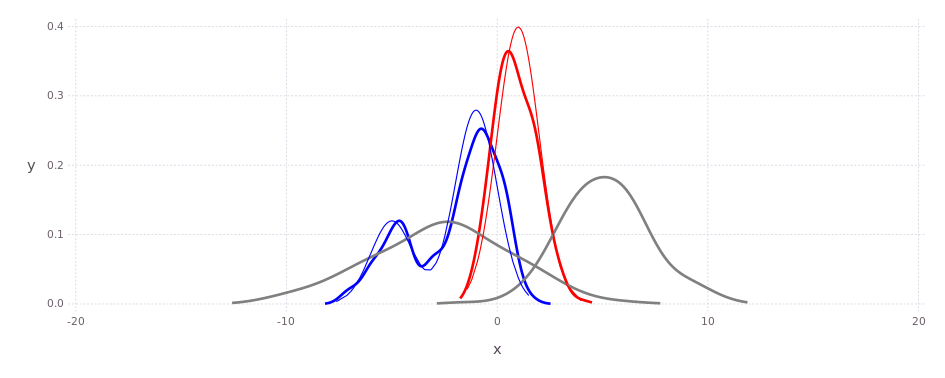

In [7]:
Gadfly.set_default_plot_size(25cm, 10cm)
plotUtil1D(cs=cs, groundtruth=groundtruth, 
  drawcurrent=true, 
  expertcolor=Dict(1=>"gray",2=>"gray")
)

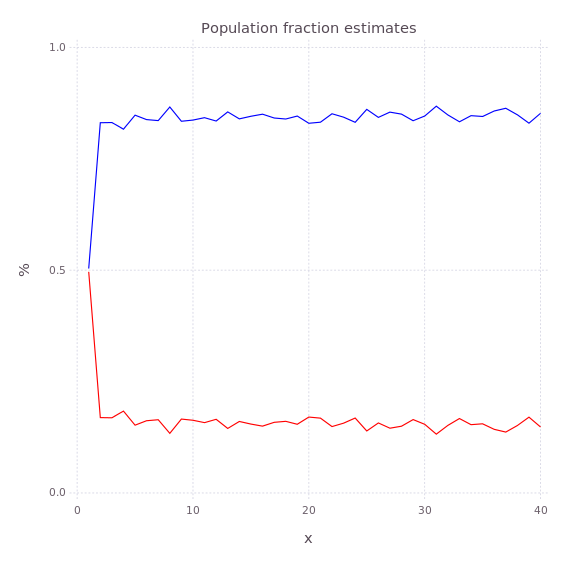

In [8]:
# proxy to convergence of classification algorithm, always available from stats structure
Gadfly.set_default_plot_size(15cm, 15cm)
plotPopulationFraction(params,stats)

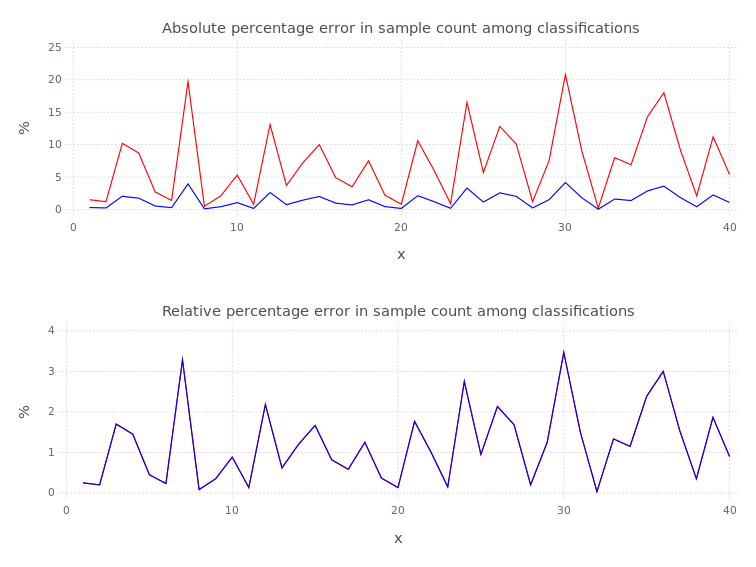

In [9]:
# only available when ground truth data is available
Gadfly.set_default_plot_size(20cm, 15cm)
plotClassificationStats(params, dbg)

In [43]:
# ### [1.0] Classification algorithm part 1 of 2 -- the measurement, generalized expectation maximization (EM) type procedure
# c1_meas = deepcopy(c1_expert)
# c2_meas = deepcopy(c2_expert)

# # [1.1] loop over cluster assignment sample drawing process
# dbg = defaultDebugResults()
# stats = ClassificationStats()
# stats.ESTBELIEF[1] = BallTreeDensity[]
# stats.ESTBELIEF[2] = BallTreeDensity[]
# stats.POPFRAC = zeros(2,params.EMiters) #Array{Float64,2}()

# assigned = zeros(Int, length(data.samples))
# prevassigned = rand(Categorical([0.5;0.5]),length(data.samples))
# for m in 1:params.EMiters # EM iterations per measurement cycle, this is a tuning parameter -> more iterations should assymptote to true assignment distribution
#   # [1.2] numerically approximate a Bayesian prior -- (interpret as Dirichlet sampling process with some implicit concentration parameter)

#   # evaluate the point likelihood of being in each cluster
#   c1_likelihoods = evaluateDualTree(c1_meas, data.samples)
#   c2_likelihoods = evaluateDualTree(c2_meas, data.samples)

#   # [1.3] assign cluster as sampling from categorical distribution
#   weights = [c1_likelihoods';c2_likelihoods'];
#   assigned = zeros(size(weights,2))
#   popFrac = [sum(prevassigned .== 1); sum(prevassigned .== 2)]/(0.0+length(data.samples))
#   stats.POPFRAC[:,m] = popFrac'
#   for i in 1:size(weights,2)
#     p = vec(weights[:,i])
#     p = p/sum(p) # renormalize to valid probability distribution
#     sel = false ?   rand( Categorical( p ) )   :   round(Int,sdc2(popFrac, p))
#     assigned[i] =  sel
#   end
#   prevassigned = deepcopy(assigned)
#   c1_assigned = data.samples[assigned .== 1]
#   c2_assigned = data.samples[assigned .== 2]

# #   push!(dbg.ASSIGNED, assigned)

#   # build new intermediate cluster density estimates
#   # but subsample to fair chance and practically computable sets first
#   len1 = length(c1_assigned)
#   len2 = length(c2_assigned)
#   c1_assigned_pts = StatsBase.sample(c1_assigned, WeightVec(1.0/len1*ones(len1)), params.Mfair, replace=false)
#   c2_assigned_pts = StatsBase.sample(c2_assigned, WeightVec(1.0/len2*ones(len2)), params.Mfair, replace=false)
#   c1_meas = kde!(c1_assigned_pts)
#   c2_meas = kde!(c2_assigned_pts)
    
#     push!(stats.ESTBELIEF[1], deepcopy(c1_meas))
#     push!(stats.ESTBELIEF[2], deepcopy(c2_meas)) 
    
#     cs.currentBelief[1] = deepcopy(c1_meas)
#     cs.currentBelief[2] = deepcopy(c2_meas)

#   # visualize what just happened
#   pl_meas = plotKDE([c1_meas;c2_meas],c=["blue";"red"]);
#   c1_meas_y = evaluateDualTree(c1_meas, c1_assigned)
#   c2_meas_y = evaluateDualTree(c2_meas, c2_assigned)
# #   push!(pl_meas, layer(x=c1_assigned, y=c1_meas_y, Geom.point, Theme(default_color=colorant"blue"))[1])
# #   push!(pl_meas, layer(x=c2_assigned, y=c2_meas_y, Geom.point, Theme(default_color=colorant"red"))[1])
#   push!(pl_meas, groundtruth.plt_lyr_cluster[1])
#   push!(pl_meas, groundtruth.plt_lyr_cluster[2])
# #   push!(pl_meas, layer(x=data.samples, y=zeros(size(data.samples)),Geom.point)[1])
#   push!(dbg.PL_MEAS, pl_meas)

#   # find the joint distribution using expert biasing, EM measurement iteration (HMM prediction not shown in this example yet)
#   c1_meas = c1_meas * c1_expert
#   c2_meas = c2_meas * c2_expert

#   # measure classification accuracy
#   packDebugResults!(dbg, assigned, groundtruth)

# end


In [25]:
# Gadfly.set_default_plot_size(25cm, 10cm)
# pl = plotKDE([c1_expert;c2_expert],c=["gray";"gray"])

# for l in dbg.PL_MEAS[end].layers
#     push!(pl.layers, l)
# end
# pl